In [139]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

In [140]:
# 0. Base Buy / Sell Factor：抽象介面

class BaseBuyFactor(ABC):
    """
    所有「買入策略因子」的抽象基底類別
    必須實作:
        - reset()
        - generate()
    """

    def __init__(self, df, **kwargs):
        self.df = df
        self._create_atr()
        self._create_preClouse()
        self.params = kwargs
        self.factor_name = f"{self.__class__.__name__}_{kwargs}"
        self.reset()

    @abstractmethod
    def reset(self):
        """策略內部變數初始化"""
        pass

    @abstractmethod
    def generate(self) -> np.ndarray:
        """
        回傳買入訊號陣列：
        - 1 = 當天買入
        - NaN = 無操作
        """
        pass
    
    def _create_atr(self):
        df = self.df
        if "atr14" not in df or "atr21" not in df:
            high_low = df["High"] - df["Low"]
            high_close = (df["High"] - df["Close"].shift(1)).abs()
            low_close = (df["Low"] - df["Close"].shift(1)).abs()
            tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)

            df["atr14"] = tr.rolling(14).mean().fillna(0)
            df["atr21"] = tr.rolling(21).mean().fillna(0)
            
    def _create_preClouse(self):
        df = self.df
        if "preClose" not in df:
            df["preClose"] = df["Close"].shift(1)


class BaseSellFactor(ABC):
    """
    所有「賣出策略因子」的抽象基底類別
    必須實作:
        - reset()
        - generate()
    """

    def __init__(self, df, **kwargs):
        self.df = df
        self._ensure_atr()
        self.params = kwargs
        self.factor_name = f"{self.__class__.__name__}_{kwargs}"
        self.reset()

    @abstractmethod
    def reset(self):
        """初始化策略狀態"""
        pass

    @abstractmethod
    def generate(self) -> np.ndarray:
        """
        回傳賣出訊號陣列：
        - 0 = 當天賣出
        - NaN = 無操作
        """
        pass
    
    def _ensure_atr(self):
        df = self.df
        if "atr14" not in df or "atr21" not in df:
            high_low = df["High"] - df["Low"]
            high_close = (df["High"] - df["Close"].shift(1)).abs()
            low_close = (df["Low"] - df["Close"].shift(1)).abs()
            tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)

            df["atr14"] = tr.rolling(14).mean().fillna(0)
            df["atr21"] = tr.rolling(21).mean().fillna(0)

In [141]:
# 1. BreakoutBuyFactor：N 日向上突破買入

class BreakoutBuyFactor(BaseBuyFactor):
    """
    N 日向上突破：
    若今日收盤價 == 過去 xd 日最高價 → 發出買入訊號
    並且在之後 xd 天內忽略新的突破（skip_days）
    """

    def reset(self):
        self.skip_days = 0

    def generate(self):
        df = self.df
        xd = self.params["xd"]
        signal = np.full(len(df), np.nan)

        close = df["Close"].values

        for i in range(len(df)):
            if i < xd:
                continue

            # 忽略突破後的連續 N 天信號（防止瘋狂加碼）
            if self.skip_days > 0:
                self.skip_days -= 1
                continue

            rolling_high = close[i - xd + 1 : i + 1].max()

            # 收盤價創 xd 日新高 → 發出買入
            if close[i] == rolling_high:
                signal[i] = 1
                self.skip_days = xd

        return signal

In [142]:
# 2. BreakdownSellFactor：N 日向下突破賣出

class BreakdownSellFactor(BaseSellFactor):
    """
    N 日向下突破：
    若今日收盤價 == 過去 xd 日最低價 → 發出賣出訊號（清倉）
    """
    
    def reset(self):
        pass

    def generate(self):
        df = self.df
        xd = self.params["xd"]
        signal = np.full(len(df), np.nan)

        close = df["Close"].values

        for i in range(len(df)):
            if i < xd:
                continue

            rolling_low = close[i - xd + 1 : i + 1].min()

            # 收盤價創 xd 日新低 → 賣出
            if close[i] == rolling_low:
                signal[i] = 0

        return signal

In [143]:
# 3. Benchmark：基準（單純 buy & hold）

class Benchmark:
    @staticmethod
    def compute_log_ret(df: pd.DataFrame) -> pd.Series:
        """基準對數報酬率（持有一檔標的不交易）"""
        close = df["Close"]
        return np.log(close / close.shift(1))

In [144]:
# 4. Backtester：單檔股票多因子回測引擎
class Backtester:
    def __init__(self, 
                 df,
                 # 買入因子
                 buy_factors, 
                 # 賣出因子
                 sell_factors,
                 # 初始資金
                 initial_capital=1_000_000,
                 # 滑點模型
                 slippage_factors=None,
                 # 持股模型(待完成)
                 position_class=None):
        """
        df: 價格資料，index 為日期，至少包含 'Close'
        buy_factors: 買入因子設定 list
            e.g. [{"class": BreakoutBuyFactor, "xd": 60}, ...]
        sell_factors: 賣出因子設定 list
            e.g. [{"class": BreakdownSellFactor, "xd": 20}, ...]
        initial_capital: 初始資金（只用來算 equity，不做分批加減）
        """
        self.raw_df = df.copy()
        self.df = df.copy()
        self.buy_factors = buy_factors or []
        self.sell_factors = sell_factors or []
        self.initial_capital = initial_capital
        self.slippage_factors = slippage_factors or []

        self.buy_cols = []
        self.sell_cols = []
        self.result = None
        self.trades = None
        self.stats = None
        # 新增：用於儲存滑價模型實例的字典 (以 factor_name 為鍵)
        self.slippage_models = {} 
        # 新增：用於記錄所有滑價因子欄位名稱的列表 (用於迭代)
        self.slippage_cols = []
        # 新增：用於儲存被滑價取消的交易紀錄
        self.canceled_trades = None

    # ---------------------
    # 主流程
    # ---------------------
    def run(self, show_plot=False, plot_start=None, plot_end=None):
        self._apply_factors()
        self._apply_slippage_models() # 必須在 _build_position 之前
        self._build_position()
        self._compute_equity()
        self._extract_trades()
        self._extract_canceled_trades() # 新增：提取被取消的交易
        self._compute_stats()

        # 如果使用者要求 → 畫圖
        if show_plot:
            self._plot_trades(plot_start, plot_end)

        # 根據是否有滑價，決定回傳數量
        base_results = (self.result, self.trades, self.stats)
        
        if bool(self.slippage_factors):
            # 有滑價模型時，回傳 4 個值
            return (*base_results, self.canceled_trades)
        else:
            # 沒有滑價模型時，只回傳 3 個值
            return base_results

    # ---------------------
    # 產生各因子訊號欄位
    # ---------------------
    def _apply_factors(self):
        df = self.df

        df["buy_factor_trigger"] = ""
        df["sell_factor_trigger"] = ""

        # 買入因子
        for f in self.buy_factors:
            FactorClass = f["class"]
            params = {k: v for k, v in f.items() if k != "class"}
            factor = FactorClass(df, **params)

            col = factor.factor_name
            self.buy_cols.append(col)

            df[col] = factor.generate()

            # 記錄：哪個因子產生買訊
            df.loc[df[col] == 1, "buy_factor_trigger"] += (col + ";")

        # 賣出因子
        for f in self.sell_factors:
            FactorClass = f["class"]
            params = {k: v for k, v in f.items() if k != "class"}
            factor = FactorClass(df, **params)

            col = factor.factor_name
            self.sell_cols.append(col)

            df[col] = factor.generate()

            # 記錄：哪個因子產生賣訊
            df.loc[df[col] == 0, "sell_factor_trigger"] += (col + ";")

    # # ---------------------
    # # 建立 signal & position（持股狀態）
    # # ---------------------
    # def _build_position(self):
    #     df = self.df

    #     # 買入：任一買入因子 == 1 就視為買入訊號
    #     if self.buy_cols:
    #         buy_signal = df[self.buy_cols].max(axis=1)
    #     else:
    #         buy_signal = pd.Series(np.nan, index=df.index)

    #     # 賣出：任一賣出因子 == 0 就視為賣出訊號
    #     if self.sell_cols:
    #         sell_signal = df[self.sell_cols].min(axis=1)
    #     else:
    #         sell_signal = pd.Series(np.nan, index=df.index)

    #     # 綜合 signal：優先考慮賣出，其次買入
    #     combined = pd.Series(np.nan, index=df.index)

    #     combined[buy_signal == 1] = 1   # 當天出現買入事件
    #     combined[sell_signal == 0] = 0  # 當天出現賣出事件（清倉）

    #     df["raw_signal"] = combined

    #     # position: 持股狀態
    #     # 規則：最後一次非 NaN 的 signal 決定目前狀態（1=持股, 0=空手）
    #     position = combined.ffill().fillna(0)

    #     # 為了避免「當天訊號吃到當天報酬」（偷看未來）
    #     # 我們用 position.shift(1) 來決定策略報酬
    #     df["position"] = position
    
    # ---------------------
    # 建立 position (持股狀態) (新邏輯)
    # ---------------------
    def _build_position(self):
        df = self.df

        position = []
        holding = 0
        
        # 準備記錄成交價格 (如果需要更精確的回測)
        # buy_price_list = []
        # sell_price_list = []

        for i, (date, row) in enumerate(df.iterrows()):

            buy_signal = any(row[col] == 1 for col in self.buy_cols)
            sell_signal = any(row[col] == 0 for col in self.sell_cols)
            
            current_slippage_trigger = "" # 重置當天滑價紀錄

            if buy_signal and holding == 0: 
                # -------------------
                # 買入處理
                # -------------------
                can_buy = True
                final_buy_price = row["Close"] # 預設成交價
                
                # 檢查所有設定為 "buy" 的滑價模型
                for name in self.slippage_cols:
                    model = self.slippage_models[name]
                    
                    # 假設滑價模型實例可以判斷其作用對象 (action)
                    # 假設模型實例的 params 字典中存有 "action" 鍵
                    if model.params.get("action") == "buy": 
                        
                        # 假設滑價模型有 set_current_data 來更新資料
                        model.set_current_data(row) 
                        adjusted_price = model.fit_price()
                        
                        # 如果滑價計算的價格為 Inf，視為撤單（買不到）
                        if adjusted_price == np.inf:
                            can_buy = False
                            current_slippage_trigger += (name + ";")
                            break # 只要有一個滑價模型導致撤單，就停止買入
                        else:
                            # 取最差的價格 (即最高的買價) 作為最終成交價
                            final_buy_price = max(final_buy_price, adjusted_price)
                
                if can_buy:
                    holding = 1
                    # buy_price_list.append(final_buy_price) # 儲存成交價
                # else:
                    # buy_price_list.append(np.nan)

            elif sell_signal and holding == 1: 
                # -------------------
                # 賣出處理
                # -------------------
                can_sell = True
                final_sell_price = row["Close"] # 預設成交價

                # 檢查所有設定為 "sell" 的滑價模型
                for name in self.slippage_cols:
                    model = self.slippage_models[name]
                    
                    if model.params.get("action") == "sell": 
                        
                        model.set_current_data(row)
                        adjusted_price = model.fit_price()
                        
                        # 如果滑價計算的價格為 0 (或 -Inf)，視為撤單（賣不出）
                        # 註：賣出通常假設不會被撤單，但以防萬一
                        if adjusted_price == 0 or adjusted_price == -np.inf:
                            can_sell = False
                            current_slippage_trigger += (name + ";")
                            break
                        else:
                            # 取最差的價格 (即最低的賣價) 作為最終成交價
                            final_sell_price = min(final_sell_price, adjusted_price)

                if can_sell:
                    holding = 0
                    # sell_price_list.append(final_sell_price) # 儲存成交價
                # else:
                    # sell_price_list.append(np.nan)
            
            # 記錄當天的滑價觸發事件
            df.loc[date, "slippage_trigger"] = current_slippage_trigger

            # 追加今天的持倉狀態
            position.append(holding)

        df["position"] = pd.Series(position, index=df.index)
        df["raw_signal"] = df["position"].diff()
        
        # 如果需要更精確的回測，需在 trades/equity 計算中使用儲存的 buy/sell price list


    # ---------------------
    # 計算基準與策略的 equity curve
    # ---------------------
    def _compute_equity(self):
        df = self.df

        # 基準：單純買入持有的對數報酬率
        df["log_ret"] = Benchmark.compute_log_ret(df)

        # 策略報酬：用「前一天」的持股狀態乘上今天的 log return
        df["strategy_log_ret"] = df["position"].shift(1).fillna(0) * df["log_ret"]

        # 累積報酬 → 換回金額
        df["benchmark_equity"] = self.initial_capital * np.exp(df["log_ret"].cumsum())
        df["strategy_equity"] = self.initial_capital * np.exp(df["strategy_log_ret"].cumsum())
        
        # 🔥 修正第一筆 NaN = 初始資金
        df.loc[df.index[0], "benchmark_equity"] = self.initial_capital
        df.loc[df.index[0], "strategy_equity"] = self.initial_capital

        self.result = df

    # ---------------------
    # 產生交易紀錄（每筆進出場）
    # ---------------------
    def _extract_trades(self):
        df = self.result
        pos = df["position"]
        change = pos.diff()

        entries = change[change == 1].index
        exits = change[change == -1].index

        if len(entries) > len(exits):
            exits = exits.append(pd.Index([df.index[-1]]))

        records = []
        for entry_date, exit_date in zip(entries, exits):
            records.append({
                "entry_date": entry_date,
                "exit_date": exit_date,
                "entry_price": df.loc[entry_date, "Close"],
                "exit_price": df.loc[exit_date, "Close"],
                "holding_days": (exit_date - entry_date).days,
                "return_pct": df.loc[exit_date, "Close"] / df.loc[entry_date, "Close"] - 1,
                "buy_factor": df.loc[entry_date, "buy_factor_trigger"],
                "sell_factor": df.loc[exit_date, "sell_factor_trigger"],
            })

        self.trades = pd.DataFrame(records)
        
    # ---------------------
    # 產生滑價模型實例
    # ---------------------
    def _apply_slippage_models(self):
        """實例化所有滑價模型並儲存在 self.slippage_models 字典中"""
        df = self.df
        
        # 預期 slippage_factors 結構：
        # [{"class": FixedSlippage, "action": "buy", "param": 0.001}, ...]
        
        df["slippage_trigger"] = "" # 新增一個欄位來記錄滑價事件
        
        for sf in self.slippage_factors:
            SlippageClass = sf["class"]
            
            # 從設定中提取參數
            params = {k: v for k, v in sf.items() if k != "class"}
            
            # 實例化滑價類別 (假設 BaseSlippage 也有 __init__(df, **kwargs) 和 factor_name 屬性)
            model_instance = SlippageClass(df, **params)
            
            col = model_instance.factor_name # 使用滑價模型自己的 factor_name
            self.slippage_cols.append(col)
            
            # 以 factor_name 為鍵儲存實例
            self.slippage_models[col] = model_instance
            
    # ---------------------
    # 產生被滑價取消的交易紀錄
    # ---------------------
    def _extract_canceled_trades(self):
        df = self.result.copy()
        
        # 為了判斷是否為「嘗試買入但失敗」或「嘗試賣出但失敗」，需要前一天的 position
        df["prev_position"] = df["position"].shift(1).fillna(0)

        # --- 1. 篩選出被取消的買入點 ---
        canceled_buy_mask = (
            (df["buy_factor_trigger"].str.len() > 0) &  # 有買入訊號
            (df["prev_position"] == 0) &                # 試圖買入前是空手
            (df["position"] == 0) &                     # 交易後仍是空手 (買入失敗)
            (df["slippage_trigger"].str.len() > 0)      # 失敗原因是滑價觸發
        )
        
        # --- 2. 篩選出被取消的賣出點 ---
        canceled_sell_mask = (
            (df["sell_factor_trigger"].str.len() > 0) & # 有賣出訊號
            (df["prev_position"] == 1) &                # 試圖賣出前是持股
            (df["position"] == 1) &                     # 交易後仍是持股 (賣出失敗)
            (df["slippage_trigger"].str.len() > 0)      # 失敗原因是滑價觸發
        )
        
        canceled_df = df[canceled_buy_mask | canceled_sell_mask].copy()

        records = []
        for date, row in canceled_df.iterrows():
            action = "Canceled Buy" if row["prev_position"] == 0 else "Canceled Sell"
            
            records.append({
                "date": date,
                "action": action,
                "price": row["Close"], # 紀錄當天收盤價
                "signal_trigger": row["buy_factor_trigger"] if action == "Canceled Buy" else row["sell_factor_trigger"],
                "slippage_factor": row["slippage_trigger"],
                "current_holding": row["position"]
            })

        self.canceled_trades = pd.DataFrame(records)

    # ---------------------
    # 計算一些基本績效指標
    # ---------------------
    def _compute_stats(self):
        df = self.result

        # ----------------------------
        # 策略績效（strategy）
        # ----------------------------
        total_ret = df["strategy_equity"].iloc[-1] / self.initial_capital

        days = (df.index[-1] - df.index[0]).days
        years = days / 365.0 if days > 0 else 1.0
        annual_ret = (1 + total_ret) ** (1 / years) - 1 if years > 0 else total_ret

        daily_ret = df["strategy_log_ret"].dropna()
        if len(daily_ret) > 1 and daily_ret.std() > 0:
            vol = daily_ret.std() * np.sqrt(252)
            sharpe = daily_ret.mean() / daily_ret.std() * np.sqrt(252)
        else:
            vol = np.nan
            sharpe = np.nan

        equity = df["strategy_equity"]
        roll_max = equity.cummax()
        dd = equity / roll_max - 1.0
        max_dd = dd.min()

        # ----------------------------
        # 基準績效（benchmark）
        # ----------------------------
        benchmark_total_ret = df["benchmark_equity"].iloc[-1] / self.initial_capital
        benchmark_annual_ret = (1 + benchmark_total_ret) ** (1 / years) - 1 if years > 0 else benchmark_total_ret

        benchmark_daily_ret = df["log_ret"].dropna()
        if len(benchmark_daily_ret) > 1 and benchmark_daily_ret.std() > 0:
            benchmark_vol = benchmark_daily_ret.std() * np.sqrt(252)
            benchmark_sharpe = benchmark_daily_ret.mean() / benchmark_daily_ret.std() * np.sqrt(252)
        else:
            benchmark_vol = np.nan
            benchmark_sharpe = np.nan

        bench_equity = df["benchmark_equity"]
        bench_roll_max = bench_equity.cummax()
        bench_dd = bench_equity / bench_roll_max - 1.0
        benchmark_max_dd = bench_dd.min()

        # ----------------------------
        # 統整最終績效（中文）
        # ----------------------------
        self.stats = {
            "策略_總報酬率": total_ret,
            "策略_年化報酬率": annual_ret,
            "策略_年化波動率": vol,
            "策略_Sharpe": sharpe,
            "策略_最大回撤": max_dd,
            "策略_交易次數": 0 if self.trades is None else len(self.trades),

            "基準_總報酬率": benchmark_total_ret,
            "基準_年化報酬率": benchmark_annual_ret,
            "基準_年化波動率": benchmark_vol,
            "基準_Sharpe": benchmark_sharpe,
            "基準_最大回撤": benchmark_max_dd,
        }

        
    # =========================================================
    # ★ 交易視覺化
    # =========================================================
    def _plot_trades(self, start=None, end=None):
        df = self.result.copy()
        trades = self.trades

        if start:
            start = pd.to_datetime(start)
            df = df[df.index >= start]
        if end:
            end = pd.to_datetime(end)
            df = df[df.index <= end]

        plt.figure(figsize=(18, 6))

        # ---- 黑色收盤線 ----
        plt.plot(df.index, df["Close"], color="black", label="Close")

        # ---- 藍色底色 ----
        plt.fill_between(df.index, 0, df["Close"], color="blue", alpha=0.05)

        # ---- 逐筆畫出交易 ----
        for _, t in trades.iterrows():
            buy = t["entry_date"]
            sell = t["exit_date"]
            buy_price = t["entry_price"]
            sell_price = t["exit_price"]
            pnl = sell_price - buy_price
            pnl_rate = t["return_pct"]

            color = "green" if pnl > 0 else "red"

            # 區間 mask
            mask = (df.index >= buy) & (df.index <= sell)

            # 區間背景
            plt.fill_between(df.index[mask],
                            0, df["Close"][mask],
                            color=color, alpha=0.28)

            # Buy / Sell 散點
            plt.scatter(buy, buy_price, color="blue", s=80)
            plt.scatter(sell, sell_price, color="orange", s=80)

            # ⭐ 取得觸發策略名稱
            buy_label = df.loc[buy, "buy_factor_trigger"] if "buy_factor_trigger" in df.columns else ""
            sell_label = df.loc[sell, "sell_factor_trigger"] if "sell_factor_trigger" in df.columns else ""

            # 暫時註解掉文字不然太亂了
            # TODO： 到時候用參數選擇要關還開
            # # ⭐ 在圖上標文字
            # plt.text(buy, buy_price,
            #         f"{buy_label}",
            #         fontsize=9, color="blue",
            #         ha="right", va="bottom")

            # plt.text(sell, sell_price,
            #         f"{sell_label}",
            #         fontsize=9, color="orange",
            #         ha="left", va="top")

            # 盈虧數字
            plt.text(sell, sell_price,
                    f"{pnl:+.2f} ({pnl_rate:+.2f}%)",
                    color=color, fontsize=9,
                    ha="left", va="bottom")

        plt.title("Backtest Trade Visualization")
        plt.grid(True)
        plt.legend()
        plt.show()

In [145]:
# 下載特斯拉資料作為範例

import yfinance as yf

df = yf.download("TSLA", start="2020-01-01")
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.droplevel(1)  # 避免 MultiIndex 問題

df

/var/folders/k0/mjnvdkdj7sn_zbtz76h68xr40000gn/T/ipykernel_67953/3616061124.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("TSLA", start="2020-01-01")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
2020-01-02,28.684000,28.713333,28.114000,28.299999,142981500
2020-01-03,29.534000,30.266666,29.128000,29.366667,266677500
2020-01-06,30.102667,30.104000,29.333332,29.364668,151995000
2020-01-07,31.270666,31.441999,30.224001,30.760000,268231500
2020-01-08,32.809334,33.232666,31.215334,31.580000,467164500
...,...,...,...,...,...
2025-11-11,439.619995,442.489990,432.359985,439.399994,60533200
2025-11-12,430.600006,442.329987,426.559998,442.149994,58513500
2025-11-13,401.989990,424.500000,396.339996,423.130005,118948000


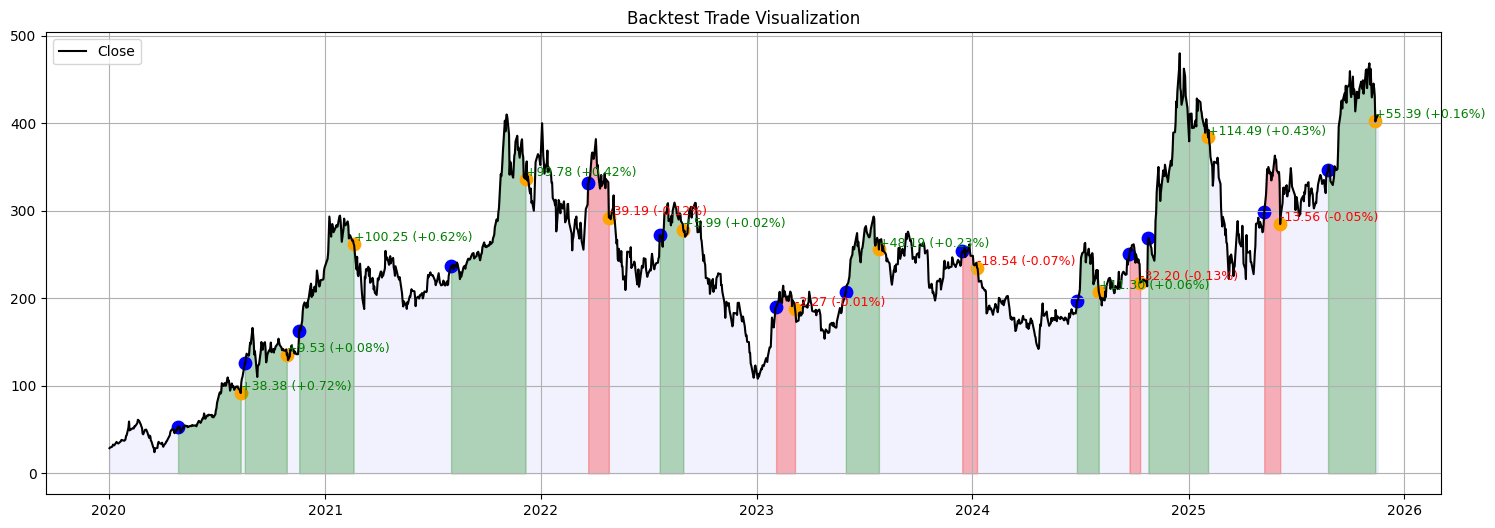

=== 績效指標 ===
策略_總報酬率 : 6.295626038752062
策略_年化報酬率 : 0.40214532104605105
策略_年化波動率 : 0.3919112624913072
策略_Sharpe : 0.8009694010511448
策略_最大回撤 : -0.3800337753338253
策略_交易次數 : 14
基準_總報酬率 : 14.256031697469094
基準_年化報酬率 : 0.5895871103592971
基準_年化波動率 : 0.6682367444956531
基準_Sharpe : 0.6784388091800972
基準_最大回撤 : -0.736322174421913

=== 交易紀錄（前 5 筆） ===
  entry_date  exit_date  entry_price  exit_price  holding_days  return_pct  \
0 2020-04-27 2020-08-11    53.250000   91.625999           106    0.720676   
1 2020-08-18 2020-10-28   125.806000  135.339996            71    0.075783   
2 2020-11-18 2021-02-18   162.213333  262.459991            92    0.617993   
3 2021-08-02 2021-12-06   236.556671  336.336670           126    0.421802   
4 2022-03-22 2022-04-26   331.326660  292.140015            35   -0.118272   

                                          buy_factor  \
0                      BreakoutBuyFactor_{'xd': 42};   
1                      BreakoutBuyFactor_{'xd': 60};   
2                

<Axes: xlabel='Date'>

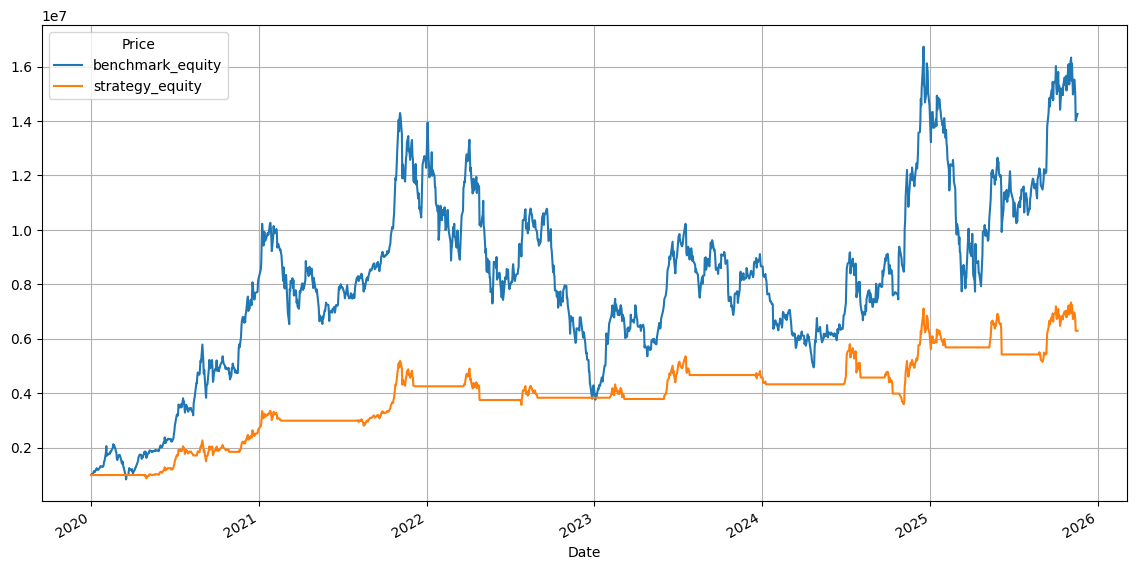

In [146]:
# Test 1 - 用突破因子買入與賣出
# 設定買入因子
buy_factors = [
    {"class": BreakoutBuyFactor, "xd": 60},
    {"class": BreakoutBuyFactor, "xd": 42},
]

# 設定賣出因子
sell_factors = [
    {"class": BreakdownSellFactor, "xd": 120},
    {"class": BreakdownSellFactor, "xd": 20}
]

# 執行單支股票回測
# 參數：
# df: 價格資料，index 為日期，至少包含 'Close'
# buy_factors: 買入因子設定 list
# sell_factors: 賣出因子設定 list
# initial_capital: 初始資金（只用來算 equity，不做分批加減）
# 回傳：
# result_df: 策略報酬率
# trades_df: 交易紀錄
# stats: 績效指標

bt_test1 = Backtester(df, buy_factors=buy_factors, sell_factors=sell_factors, initial_capital=1_000_000)
result_df_test1, trades_df_test1, stats_test1 = bt_test1.run(show_plot=True)

print("=== 績效指標 ===")
for k, v in stats_test1.items():
    print(k, ":", v)

print("\n=== 交易紀錄（前 5 筆） ===")
print(trades_df_test1.head())

# 策略 vs 基準績效曲線
result_df_test1[["benchmark_equity", "strategy_equity"]].plot(figsize=(14, 7), grid=True)

In [147]:
# 5. 可以看到績效表現不是很好，實作另一個因子 AtrStopSellFactor
# 量化投資策略會加上止盈止損策略
# AtrStopSellFactor 當作止盈止損賣出因子
class AtrStopSellFactor(BaseSellFactor):

    def reset(self):
        self.in_position = False
        self.entry_price = None

    # def _ensure_atr(self):
    #     df = self.df
    #     if "atr14" not in df or "atr21" not in df:
    #         high_low = df["High"] - df["Low"]
    #         high_close = (df["High"] - df["Close"].shift(1)).abs()
    #         low_close = (df["Low"] - df["Close"].shift(1)).abs()
    #         tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)

    #         df["atr14"] = tr.rolling(14).mean().fillna(0)
    #         df["atr21"] = tr.rolling(21).mean().fillna(0)

    def generate(self):
        df = self.df
        # self._ensure_atr()

        n_loss = self.params.get("stop_loss_n")
        n_win = self.params.get("stop_win_n")

        signal = np.full(len(df), np.nan)

        close = df["Close"].values
        atr14 = df["atr14"].values
        atr21 = df["atr21"].values

        # 找出所有買入 raw signal（由你的 buy factors 產生）
        buy_cols = [c for c in df.columns if "BuyFactor" in c]
        raw_buy = df[buy_cols].max(axis=1).fillna(0).values

        for i in range(len(df)):

            # 若今天發生買入 → 記錄 entry_price
            if raw_buy[i] == 1:
                self.in_position = True
                self.entry_price = close[i]
                continue

            # 若沒有持倉 → 略過
            if not self.in_position:
                continue

            profit = close[i] - self.entry_price
            stop_base = atr14[i] + atr21[i]

            # ---- 止盈 ----
            if n_win is not None and profit > n_win * stop_base:
                signal[i] = 0
                self.in_position = False
                self.entry_price = None
                continue

            # ---- 止損 ----
            if n_loss is not None and profit < -n_loss * stop_base:
                signal[i] = 0
                self.in_position = False
                self.entry_price = None
                continue

        return signal

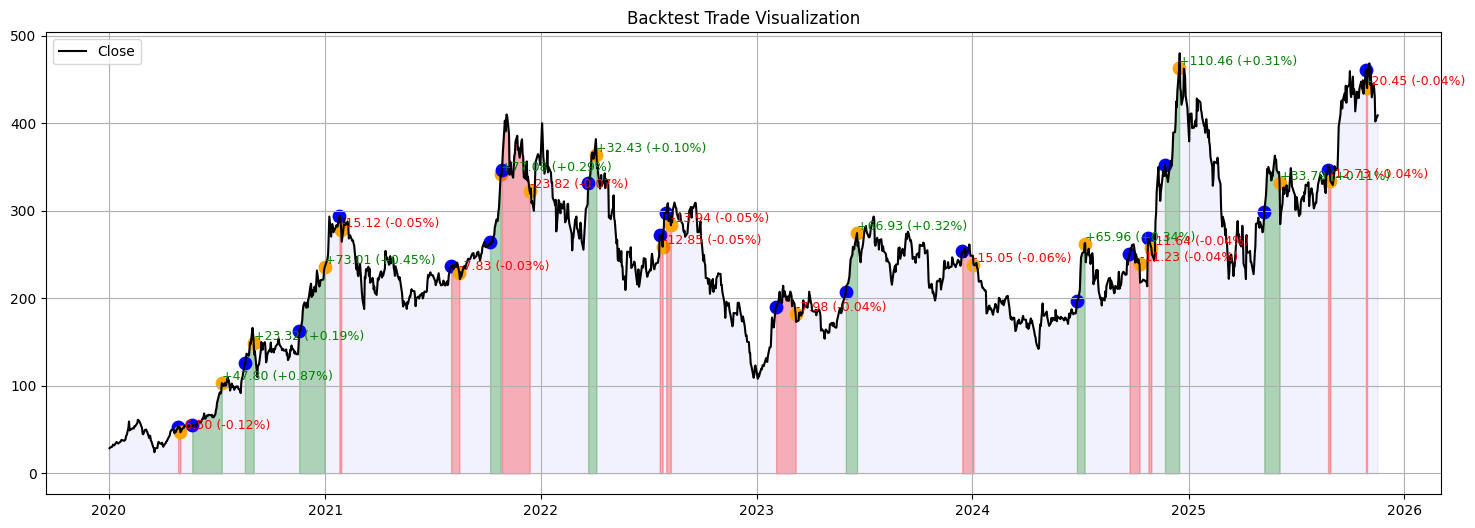

=== 績效指標 ===
策略_總報酬率 : 6.063076434472525
策略_年化報酬率 : 0.39444110101780017
策略_年化波動率 : 0.25280076221063547
策略_Sharpe : 1.2163227472591667
策略_最大回撤 : -0.24958127842484512
策略_交易次數 : 21
基準_總報酬率 : 14.256031697469094
基準_年化報酬率 : 0.5895871103592971
基準_年化波動率 : 0.6682367444956531
基準_Sharpe : 0.6784388091800972
基準_最大回撤 : -0.736322174421913

=== 交易紀錄（前 5 筆） ===
  entry_date  exit_date  entry_price  exit_price  holding_days  return_pct  \
0 2020-04-27 2020-05-01    53.250000   46.754665             4   -0.121978   
1 2020-05-21 2020-07-10    55.173332  102.976669            50    0.866421   
2 2020-08-18 2020-09-02   125.806000  149.123337            15    0.185344   
3 2020-11-18 2020-12-31   162.213333  235.223328            43    0.450086   
4 2021-01-25 2021-01-28   293.600006  278.476654             3   -0.051510   

                      buy_factor  \
0  BreakoutBuyFactor_{'xd': 42};   
1  BreakoutBuyFactor_{'xd': 60};   
2  BreakoutBuyFactor_{'xd': 60};   
3  BreakoutBuyFactor_{'xd': 42};   
4  

<Axes: xlabel='Date'>

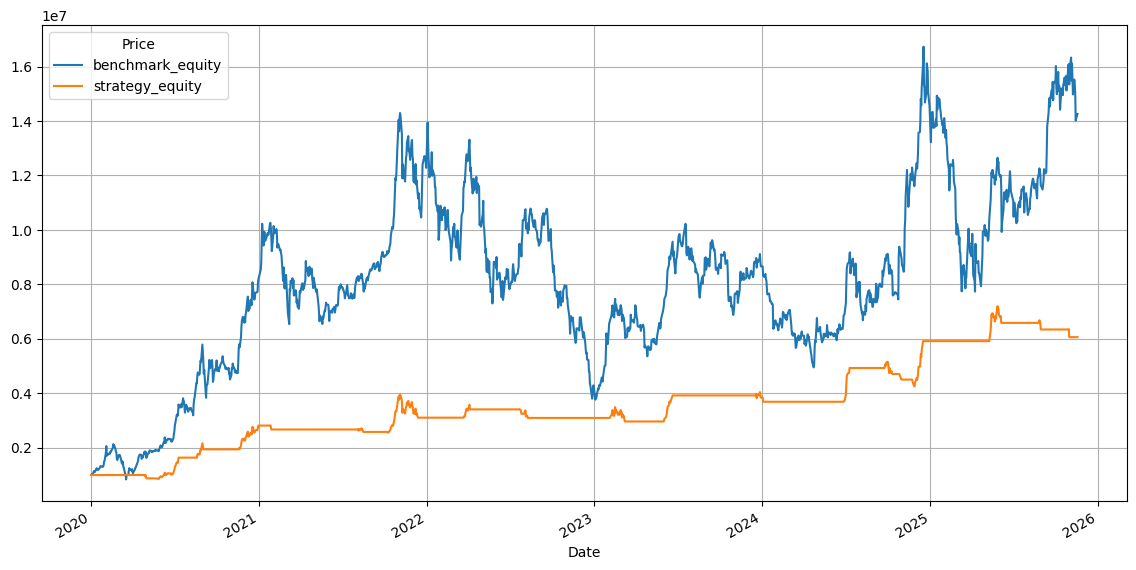

In [148]:
# Test 2 - 加入Atr因子來當作止盈止損條件
# 加入 AtrStopSellFactor 來當作止盈止損賣出因子
buy_factors = [
    {"class": BreakoutBuyFactor, "xd": 60},
    {"class": BreakoutBuyFactor, "xd": 42},
]

# 先前的賣出因子調整
sell_factors = [
    {"class": BreakdownSellFactor, "xd": 120},
    # 加上ATR止盈止損
    {"class": AtrStopSellFactor, "stop_loss_n": 0.5, "stop_win_n": 3.0}
]

bt_test2 = Backtester(df, buy_factors=buy_factors, sell_factors=sell_factors, initial_capital=1_000_000)
result_df_test2, trades_df_test2, stats_test2 = bt_test2.run(show_plot=True)

print("=== 績效指標 ===")
for k, v in stats_test2.items():
    print(k, ":", v)

print("\n=== 交易紀錄（前 5 筆） ===")
print(trades_df_test2.head())

# 策略 vs 基準績效曲線
result_df_test2[["benchmark_equity", "strategy_equity"]].plot(figsize=(14, 7), grid=True)


In [149]:
# 6. 更進一步： 量化交易會有風險控制，當天股價大量下跌的時候會果斷採取平倉(RiskStopSellFactor)
# 實作 RiskStopSellFactor 來當作風險控制賣出因子
class RiskStopSellFactor(BaseSellFactor):
    """
    風險控制：
    若今天的跌幅（昨收 - 今收） > ATR21 * pre_atr_n
    → 強制止損賣出
    """

    def reset(self):
        pass

    # -----------------------------------------------------
    # 如果 df 沒有 ATR 相關欄位，補上
    # -----------------------------------------------------
    # def _ensure_atr(self):
    #     df = self.df

    #     if "atr14" not in df.columns or "atr21" not in df.columns:
    #         high_low = df["High"] - df["Low"]
    #         high_close = (df["High"] - df["Close"].shift(1)).abs()
    #         low_close = (df["Low"] - df["Close"].shift(1)).abs()

    #         tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)

    #         df["atr14"] = tr.rolling(14).mean()
    #         df["atr21"] = tr.rolling(21).mean()

    #         df[["atr14", "atr21"]] = df[["atr14", "atr21"]].fillna(0)

    # -----------------------------------------------------
    # generate(): 回傳賣出訊號
    # -----------------------------------------------------
    def generate(self):
        df = self.df

        # 確保 ATR 欄位存在
        # self._ensure_atr()

        pre_atr_n = self.params.get("pre_atr_n", 1.5)  # 預設 1.5（與阿布一致）
        signal = np.full(len(df), np.nan)

        close = df["Close"].values
        preclose = df["Close"].shift(1).values
        atr21 = df["atr21"].values

        for i in range(1, len(df)):
            drop_amount = preclose[i] - close[i]

            # ✦ 今日跌幅超過 ATR21 × 倍數 → 強制賣出
            if drop_amount > atr21[i] * pre_atr_n:
                signal[i] = 0  # 賣出

        return signal

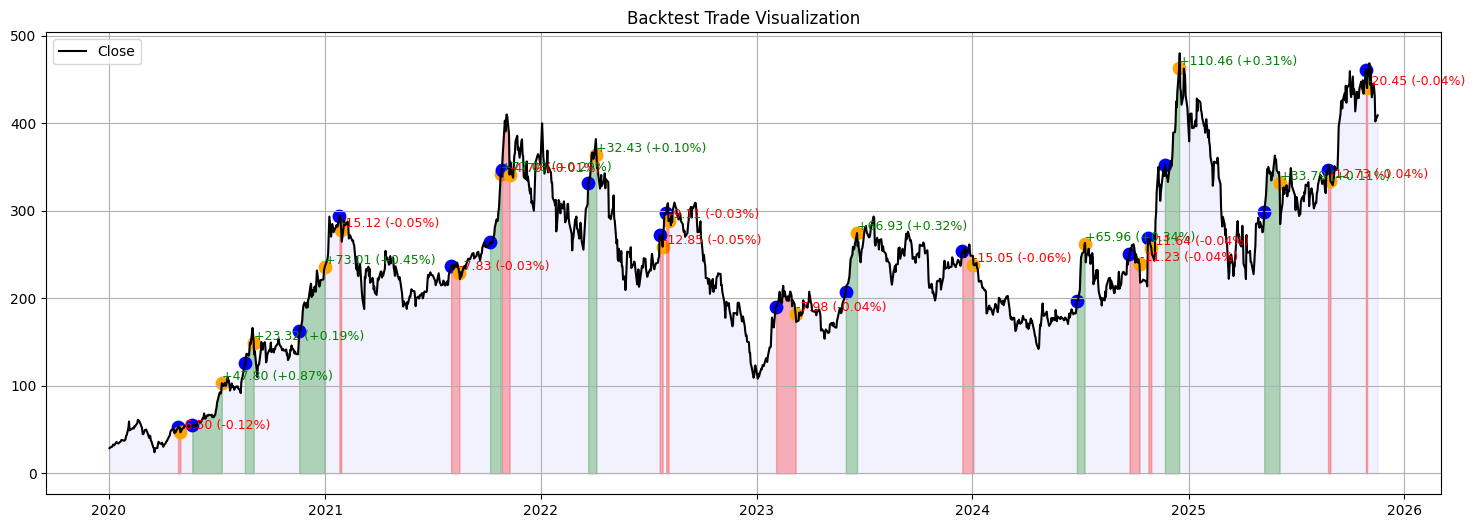

=== 績效指標 ===
策略_總報酬率 : 6.063076434472525
策略_年化報酬率 : 0.39444110101780017
策略_年化波動率 : 0.25280076221063547
策略_Sharpe : 1.2163227472591667
策略_最大回撤 : -0.24958127842484512
策略_交易次數 : 21
基準_總報酬率 : 14.256031697469094
基準_年化報酬率 : 0.5895871103592971
基準_年化波動率 : 0.6682367444956531
基準_Sharpe : 0.6784388091800972
基準_最大回撤 : -0.736322174421913

=== 交易紀錄（前 5 筆） ===
  entry_date  exit_date  entry_price  exit_price  holding_days  return_pct  \
0 2020-04-27 2020-05-01    53.250000   46.754665             4   -0.121978   
1 2020-05-21 2020-07-10    55.173332  102.976669            50    0.866421   
2 2020-08-18 2020-09-02   125.806000  149.123337            15    0.185344   
3 2020-11-18 2020-12-31   162.213333  235.223328            43    0.450086   
4 2021-01-25 2021-01-28   293.600006  278.476654             3   -0.051510   

                      buy_factor  \
0  BreakoutBuyFactor_{'xd': 42};   
1  BreakoutBuyFactor_{'xd': 60};   
2  BreakoutBuyFactor_{'xd': 60};   
3  BreakoutBuyFactor_{'xd': 42};   
4  

<Axes: xlabel='Date'>

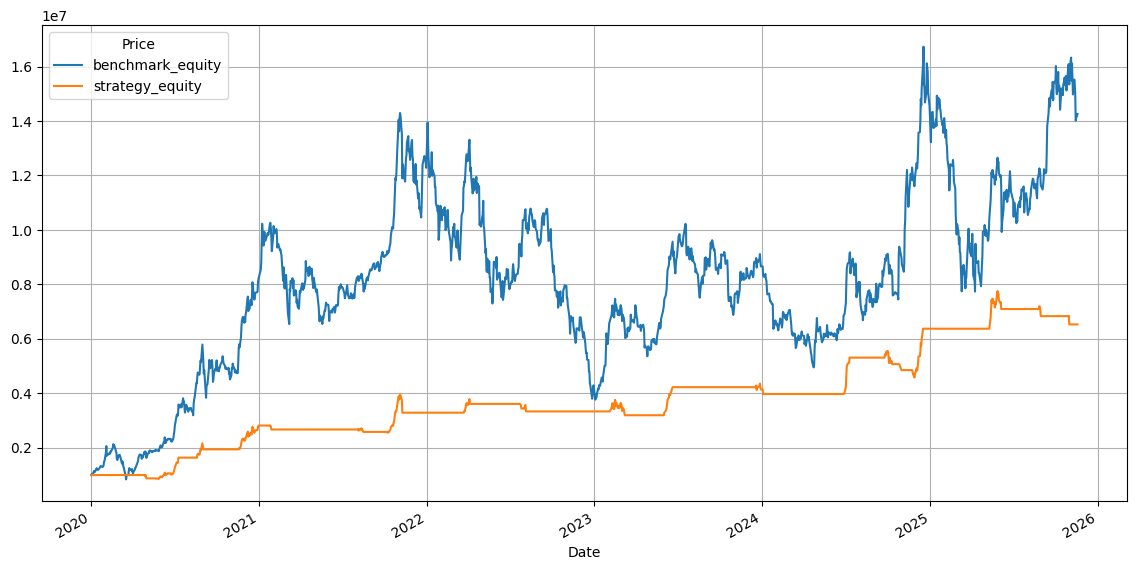

In [150]:
# Test 3 - 股價大量下跌時強制賣出
# 加入止損策略
buy_factors = [
    {"class": BreakoutBuyFactor, "xd": 60},
    {"class": BreakoutBuyFactor, "xd": 42},
]

# 先前的賣出因子調整
sell_factors = [
    {"class": BreakdownSellFactor, "xd": 120},
    # 加上ATR止盈止損
    {"class": AtrStopSellFactor, "stop_loss_n": 0.5, "stop_win_n": 3.0},
    # 加入風險控制策略
    {"class": RiskStopSellFactor, "pre_atr_n": 1.5}
]

bt_test3 = Backtester(df, buy_factors=buy_factors, sell_factors=sell_factors, initial_capital=1_000_000)
result_df_test3, trades_df_test3, stats_test3 = bt_test3.run(show_plot=True)

print("=== 績效指標 ===")
for k, v in stats_test2.items():
    print(k, ":", v)

print("\n=== 交易紀錄（前 5 筆） ===")
print(trades_df_test3.head())

# 策略 vs 基準績效曲線
result_df_test3[["benchmark_equity", "strategy_equity"]].plot(figsize=(14, 7), grid=True)

In [151]:
# 7. 再加入一個保護性止盈策略試試（CloseAtrStopSellFactor），但這樣做效益不大，只是為了實驗
class CloseAtrStopSellFactor(BaseSellFactor):
    """
    Trailing ATR 止盈
    close_atr_n：觸發止盈的 ATR 倍數（如 1.2）
    """

    def reset(self):
        self.in_position = False
        self.entry_price = None
        self.max_close = None  # 持倉期間最高收盤價

    # def _ensure_atr(self):
    #     df = self.df
    #     if "atr21" not in df:
    #         high_low = df["High"] - df["Low"]
    #         high_close = (df["High"] - df["Close"].shift(1)).abs()
    #         low_close = (df["Low"] - df["Close"].shift(1)).abs()
    #         tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    #         df["atr21"] = tr.rolling(21).mean().fillna(0)

    def generate(self):
        df = self.df
        close_atr_n = self.params.get("close_atr_n", 1.2)

        # self._ensure_atr()

        close = df["Close"].values
        atr21 = df["atr21"].values

        signal = np.full(len(df), np.nan)

        # 找出所有買入訊號（你的邏輯：col 名稱中有 BuyFactor）
        buy_cols = [c for c in df.columns if "BuyFactor" in c]
        raw_buy = df[buy_cols].max(axis=1).fillna(0).values

        for i in range(len(df)):

            # ---------- 若當天觸發買入 ----------
            if raw_buy[i] == 1:
                self.in_position = True
                self.entry_price = close[i]
                self.max_close = close[i]
                continue

            # ---------- 若沒有持倉 ----------
            if not self.in_position:
                continue

            # 更新最大價格
            self.max_close = max(self.max_close, close[i])

            # Step 1：必須先獲利超過 1×ATR
            if self.max_close - self.entry_price <= atr21[i]:
                continue

            # Step 2：下降幅度超過 ATR 倍數 ⇒ 觸發止盈
            if (self.max_close - close[i]) > atr21[i] * close_atr_n:
                signal[i] = 0  # 賣出
                self.in_position = False
                self.entry_price = None
                self.max_close = None

        return signal

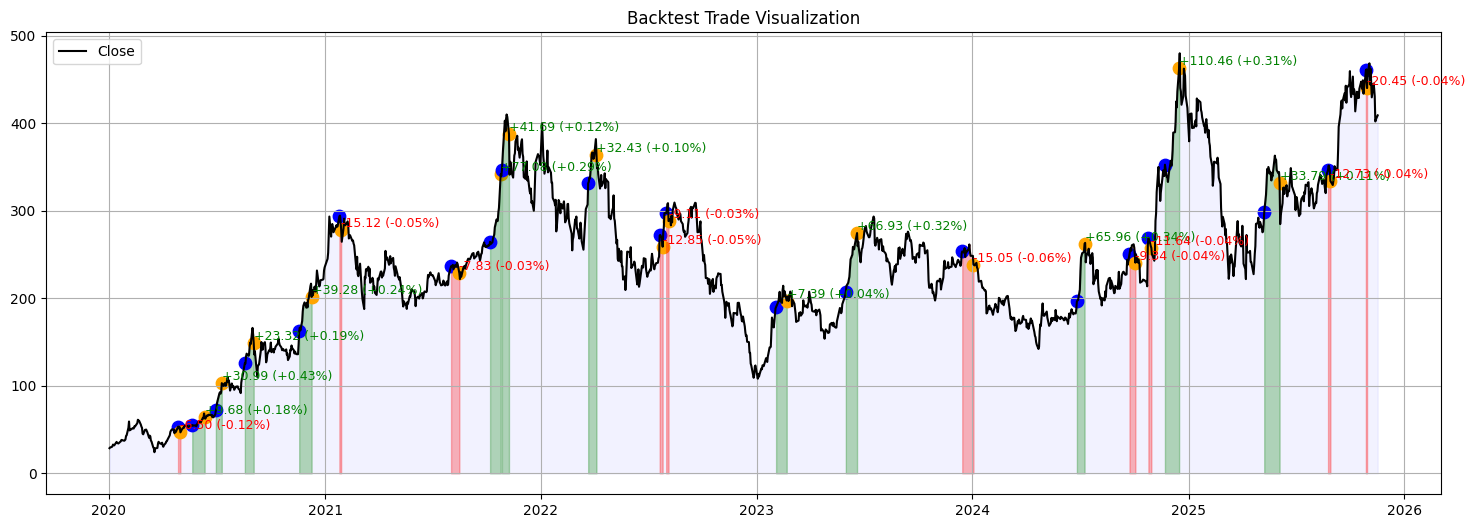

=== 績效指標 ===
策略_總報酬率 : 6.2596249702868665
策略_年化報酬率 : 0.40096608687168955
策略_年化波動率 : 0.21894364140451872
策略_Sharpe : 1.4292740878561059
策略_最大回撤 : -0.16902738696124686
策略_交易次數 : 22
基準_總報酬率 : 14.256031697469094
基準_年化報酬率 : 0.5895871103592971
基準_年化波動率 : 0.6682367444956531
基準_Sharpe : 0.6784388091800972
基準_最大回撤 : -0.736322174421913

=== 交易紀錄（前 5 筆） ===
  entry_date  exit_date  entry_price  exit_price  holding_days  return_pct  \
0 2020-04-27 2020-05-01    53.250000   46.754665             4   -0.121978   
1 2020-05-21 2020-06-11    55.173332   64.856003            21    0.175495   
2 2020-06-30 2020-07-10    71.987335  102.976669            10    0.430483   
3 2020-08-18 2020-09-02   125.806000  149.123337            15    0.185344   
4 2020-11-18 2020-12-09   162.213333  201.493332            21    0.242150   

                      buy_factor  \
0  BreakoutBuyFactor_{'xd': 42};   
1  BreakoutBuyFactor_{'xd': 60};   
2  BreakoutBuyFactor_{'xd': 42};   
3  BreakoutBuyFactor_{'xd': 60};   
4 

<Axes: xlabel='Date'>

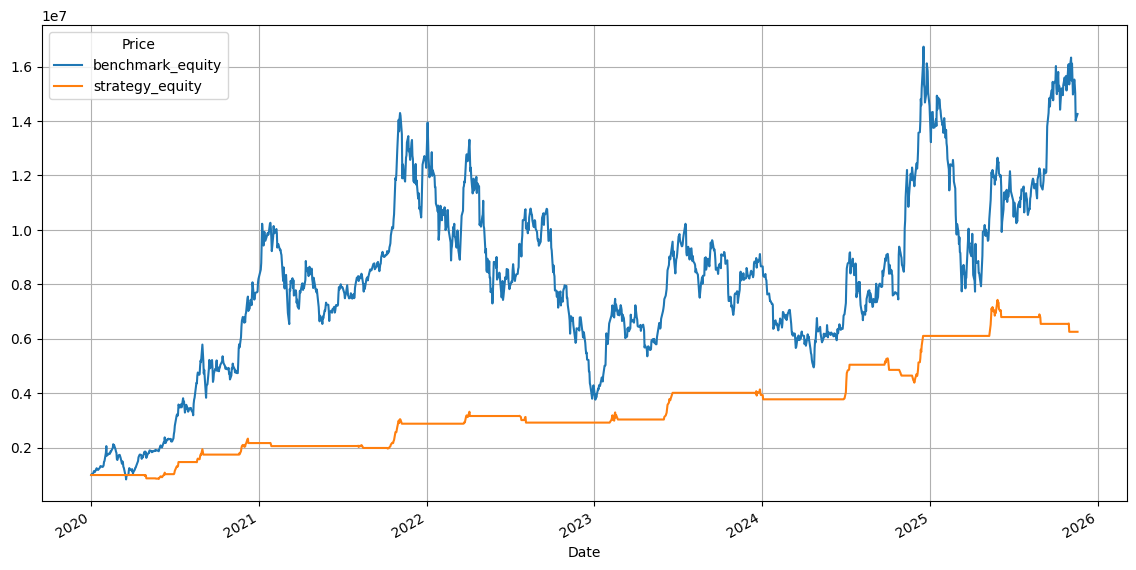

In [152]:
# Test 4 - 加入保護性止盈策略試試
# 加入保護性止盈策略
buy_factors = [
    {"class": BreakoutBuyFactor, "xd": 60},
    {"class": BreakoutBuyFactor, "xd": 42},
]

# 先前的賣出因子調整
sell_factors = [
    {"class": BreakdownSellFactor, "xd": 120},
    # 加上ATR止盈止損
    {"class": AtrStopSellFactor, "stop_loss_n": 0.5, "stop_win_n": 3.0},
    # 加入風險控制策略
    {"class": RiskStopSellFactor, "pre_atr_n": 1.5},
    # 加入保護性止盈策略
    {"class": CloseAtrStopSellFactor, "close_atr_n": 1.2}
]

bt_test4 = Backtester(df, buy_factors=buy_factors, sell_factors=sell_factors, initial_capital=1_000_000)
result_df_test4, trades_df_test4, stats_test4 = bt_test4.run(show_plot=True)

print("=== 績效指標 ===")
for k, v in stats_test4.items():
    print(k, ":", v)

print("\n=== 交易紀錄（前 5 筆） ===")
print(trades_df_test4.head())

# 策略 vs 基準績效曲線
result_df_test4[["benchmark_equity", "strategy_equity"]].plot(figsize=(14, 7), grid=True)

In [153]:
# 8.1.3節內容：滑點買入與賣出價格確立及策略實現

In [154]:
# 實作 BaseSlippageBuy 介面
class BaseSlippage(ABC):
    """
    所有滑價模型的抽象基底類別。
    必須實現 set_current_data() 和 fit_price()。
    """
    def __init__(self, df: pd.DataFrame, **kwargs):
        # 整個 DataFrame (用於前置計算，如 ATR)
        self.df = df
        # 儲存所有參數，包括 action
        self.params = kwargs 
        # 產生唯一的 factor_name，用於在 Backtester 中儲存和識別
        action = kwargs.get('action', 'default')
        # 假設滑價模型也像因子一樣需要 _ensure_atr
        # self._ensure_atr() 
        self.factor_name = f"{self.__class__.__name__}_{action}_{kwargs}"
        
        # 每天迴圈中傳入的單行數據
        self.current_row = None 
        
        # 確保有 action 參數
        if 'action' not in kwargs or kwargs['action'] not in ['buy', 'sell']:
            raise ValueError("BaseSlippage 必須在參數中指定 action='buy' 或 action='sell'")

    # 新增：接收當天數據的方法
    def set_current_data(self, row: pd.Series):
        """在 Backtester 每日迴圈中被呼叫，傳入當天數據"""
        self.current_row = row

    @abstractmethod
    def fit_price(self) -> float:
        """
        回傳滑價後的成交價格。
        - 買入撤單回傳 np.inf
        - 賣出撤單回傳 np.inf (或 0 / -np.inf，取決於設計)
        """
        pass

In [155]:
# 實作 SlippageOpenGap
class SlippageOpenGap(BaseSlippage):
    
    # 這裡的 df 是整個價格資料，kwargs 包含 open_down_rate 和 action
    def __init__(self, df, open_down_rate=0.07, **kwargs): 
        # 確保 open_down_rate 參數被正確儲存
        kwargs['open_down_rate'] = open_down_rate
        super().__init__(df, **kwargs)
        self.open_down_rate = open_down_rate
        
        # (這裡可以放任何前置計算，例如計算波動率等)

    # set_current_data 會繼承自 BaseSlippage，負責更新 self.current_row

    def fit_price(self):
        # 確保當天數據已傳入
        if self.current_row is None:
            return np.inf # 或拋出錯誤

        row = self.current_row
        
        # 假設 preClose 是前一天的 Close 價 (通常需要 shift 取得)
        # 如果 df 中沒有 preClose 欄位，這部分邏輯需要調整。
        # 這裡我們假設 row["preClose"] 是正確的前收盤價。
        open_price = row["Open"]
        pre_close = row.get("preClose")
        high = row["High"]
        low = row["Low"]

        # 1. 開盤大跌 → 撤單
        if (
            pre_close > 0 
            and open_price / pre_close < (1 - self.open_down_rate)
        ):
            # 必須回傳 np.inf 才能讓 Backtester 判斷為撤單
            return np.inf 

        # 2. 均價成交
        price = (high + low) / 2
        # 不再需要 self.buy_price 屬性，直接回傳即可
        return price


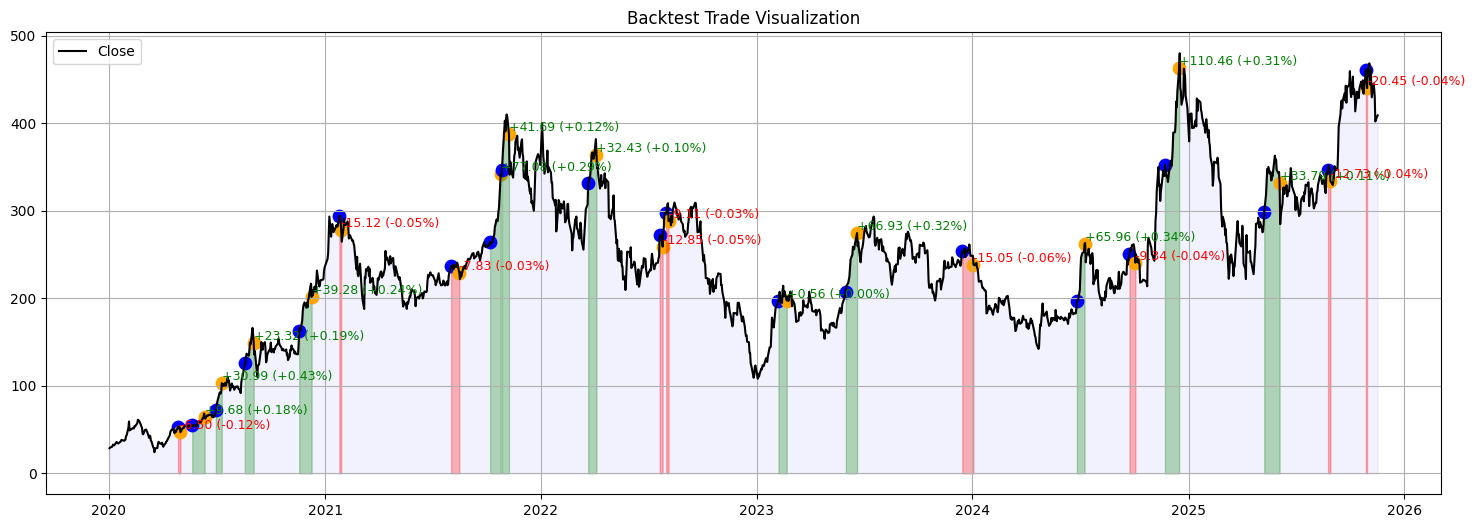

=== 績效指標 ===
策略_總報酬率 : 6.315480880868844
策略_年化報酬率 : 0.4027936122605569
策略_年化波動率 : 0.21833065887036607
策略_Sharpe : 1.440229077231057
策略_最大回撤 : -0.15772894819624694
策略_交易次數 : 21
基準_總報酬率 : 14.256031697469094
基準_年化報酬率 : 0.5895871103592971
基準_年化波動率 : 0.6682367444956531
基準_Sharpe : 0.6784388091800972
基準_最大回撤 : -0.736322174421913

=== 交易紀錄（前 5 筆） ===
  entry_date  exit_date  entry_price  exit_price  holding_days  return_pct  \
0 2020-04-27 2020-05-01    53.250000   46.754665             4   -0.121978   
1 2020-05-21 2020-06-11    55.173332   64.856003            21    0.175495   
2 2020-06-30 2020-07-10    71.987335  102.976669            10    0.430483   
3 2020-08-18 2020-09-02   125.806000  149.123337            15    0.185344   
4 2020-11-18 2020-12-09   162.213333  201.493332            21    0.242150   

                      buy_factor  \
0  BreakoutBuyFactor_{'xd': 42};   
1  BreakoutBuyFactor_{'xd': 60};   
2  BreakoutBuyFactor_{'xd': 42};   
3  BreakoutBuyFactor_{'xd': 60};   
4  Br

<Axes: xlabel='Date'>

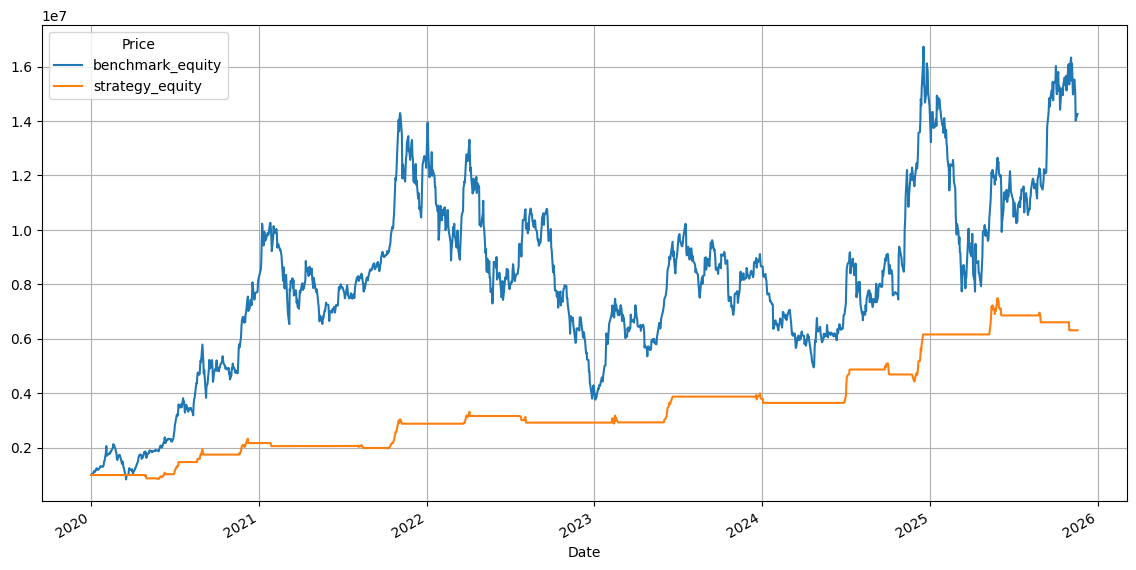

In [158]:
# Test 5 - 滑點買入
buy_factors = [
    {"class": BreakoutBuyFactor, "xd": 60},
    {"class": BreakoutBuyFactor, "xd": 42},
]

# 先前的賣出因子調整
sell_factors = [
    {"class": BreakdownSellFactor, "xd": 120},
    # 加上ATR止盈止損
    {"class": AtrStopSellFactor, "stop_loss_n": 0.5, "stop_win_n": 3.0},
    # 加入風險控制策略
    {"class": RiskStopSellFactor, "pre_atr_n": 1.5},
    # 加入保護性止盈策略
    {"class": CloseAtrStopSellFactor, "close_atr_n": 1.2}
]

# 滑點買入帶入
slippage_factors = [
    {"class": SlippageOpenGap, "open_down_rate": 0.01, "action": "buy"}
]

bt_test5 = Backtester(df, buy_factors=buy_factors, sell_factors=sell_factors, initial_capital=1_000_000, slippage_factors=slippage_factors)
result_df_test5, trades_df_test5, stats_test5, canceled_trades_df_test5 = bt_test5.run(show_plot=True)

print("=== 績效指標 ===")
for k, v in stats_test5.items():
    print(k, ":", v)

print("\n=== 交易紀錄（前 5 筆） ===")
print(trades_df_test5.head())

# 策略 vs 基準績效曲線
result_df_test5[["benchmark_equity", "strategy_equity"]].plot(figsize=(14, 7), grid=True)